In [ ]:
import os
import sys
import re
import json
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.decomposition import NMF
from sklearn.manifold import TSNE
from sklearn.cluster import KMeans
import seaborn as sns
from sklearn.decomposition import TruncatedSVD


In [ ]:
try:
    from wordcloud import WordCloud
except ImportError:
    subprocess.check_call([sys.executable, "-m", "pip", "install", "wordcloud"])
    from wordcloud import WordCloud


In [3]:
# Download necessary NLTK data (if not already available)
nltk.download('stopwords')


[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [4]:
# Data Loading & Cleaning
def load_jsonl(filepath):
    data = []
    with open(filepath, 'r', encoding='utf-8') as f:
        for line in f:
            data.append(json.loads(line))
    return pd.DataFrame(data)

# Load the reviews data
reviews_filepath = "All_Beauty.jsonl"
reviews_df = load_jsonl(reviews_filepath)

def clean_text(text):

    text = text.lower()
    text = re.sub(r'[^a-z0-9\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

# Create a new column for cleaned review text.
reviews_df['cleaned_text'] = reviews_df['text'].apply(clean_text)


Classification Report for Sentiment Classifier:
              precision    recall  f1-score   support

    negative       0.86      0.76      0.81     35923
    positive       0.93      0.97      0.95    125383

    accuracy                           0.92    161306
   macro avg       0.90      0.86      0.88    161306
weighted avg       0.92      0.92      0.92    161306



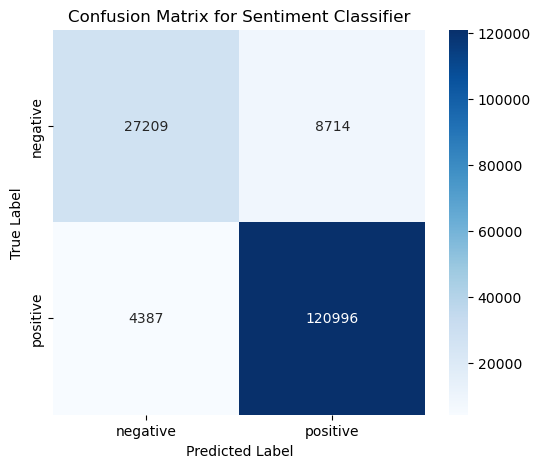

In [5]:
# Supervised Sentiment Classification
sentiment_df = reviews_df[reviews_df['rating'] != 3].copy()
sentiment_df['binary_sentiment'] = sentiment_df['rating'].apply(lambda x: 'positive' if x >= 4 else 'negative')

# TF-IDF vectorization on cleaned text.
tfidf_vectorizer = TfidfVectorizer(stop_words='english', max_df=0.95, min_df=5)
X = tfidf_vectorizer.fit_transform(sentiment_df['cleaned_text'])
y = sentiment_df['binary_sentiment']

# Train-test split.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

# Train a Logistic Regression classifier.
clf = LogisticRegression(max_iter=1000, random_state=42)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

# Evaluate classifier performance.
print("Classification Report for Sentiment Classifier:")
print(classification_report(y_test, y_pred))

# Plot the confusion matrix.
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['negative','positive'], yticklabels=['negative','positive'])
plt.title("Confusion Matrix for Sentiment Classifier")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Topics from NMF:
Topic 1: like, br, one, get, would, really, dont, good, im, time
Topic 2: hair, use, soft, shampoo, thick, brush, color, dry, long, conditioner
Topic 3: product, would, good, using, used, recommend, products, review, received, time
Topic 4: great, love, price, works, easy, quality, well, color, perfect, really
Topic 5: skin, use, face, using, oil, dry, cream, products, used, sensitive


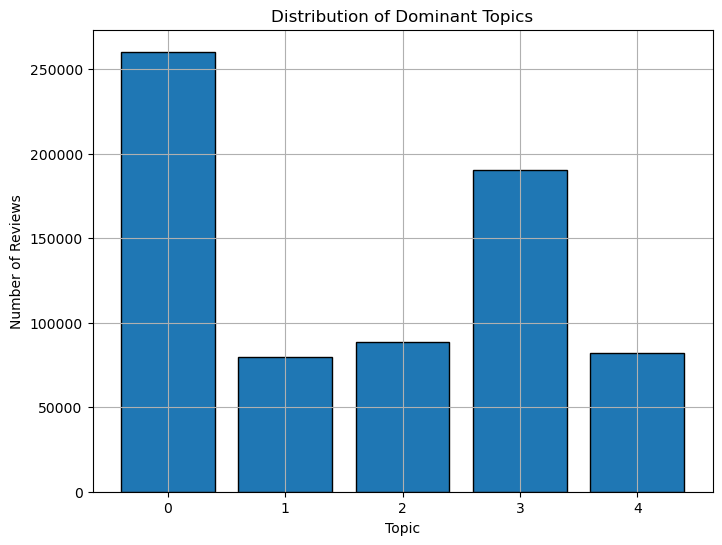

In [6]:
# Topic Modeling using NMF
stop_words_list = stopwords.words('english')
vectorizer_count = CountVectorizer(stop_words=stop_words_list, max_df=0.9, min_df=5)
dtm = vectorizer_count.fit_transform(reviews_df['cleaned_text'])

# Fit an NMF model to extract topics.
num_topics = 5
nmf_model = NMF(n_components=num_topics, random_state=42)
W = nmf_model.fit_transform(dtm)  
H = nmf_model.components_        

def display_topics(model, feature_names, num_top_words):
    topics = {}
    for topic_idx, topic in enumerate(model.components_):
        top_words = [feature_names[i] for i in topic.argsort()[:-num_top_words - 1:-1]]
        topics[f"Topic {topic_idx+1}"] = top_words
    return topics

num_top_words = 10
feature_names = vectorizer_count.get_feature_names_out()
topics = display_topics(nmf_model, feature_names, num_top_words)

print("Topics from NMF:")
for topic, words in topics.items():
    print(f"{topic}: {', '.join(words)}")

# Assign each review its dominant topic.
reviews_df['dominant_topic'] = W.argmax(axis=1)

# Visualize the distribution of dominant topics.
topic_counts = reviews_df['dominant_topic'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(topic_counts.index.astype(str), topic_counts.values, edgecolor='black')
plt.title('Distribution of Dominant Topics')
plt.xlabel('Topic')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()


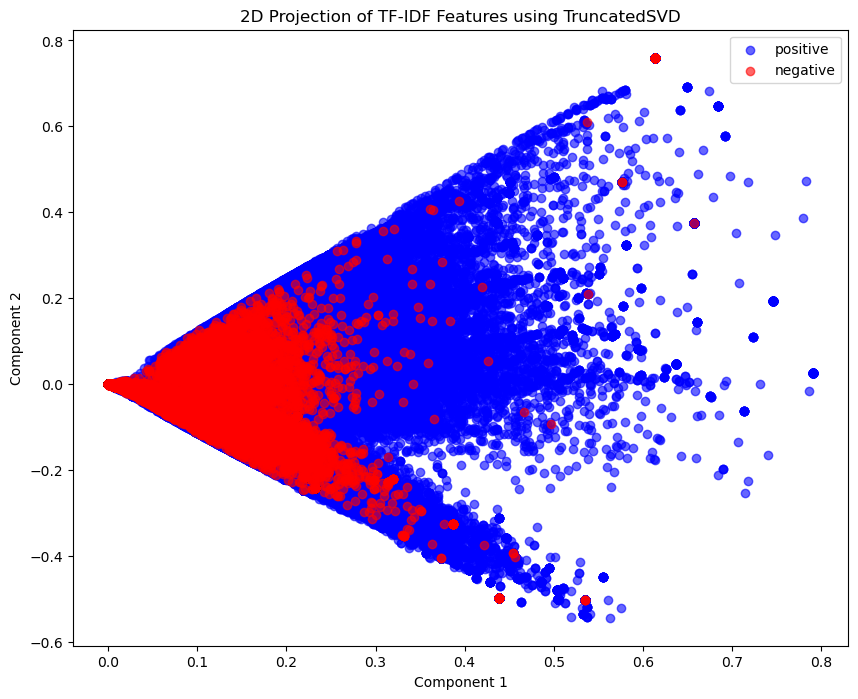

In [7]:
# Visualizing TF-IDF Features using TruncatedSVD
svd_2d = TruncatedSVD(n_components=2, random_state=42)
X_2d = svd_2d.fit_transform(X)

# Create a DataFrame for the reduced features.
reduced_df = pd.DataFrame(X_2d, columns=['Component 1', 'Component 2'])
reduced_df['binary_sentiment'] = sentiment_df['binary_sentiment'].values

plt.figure(figsize=(10, 8))
colors = {'positive': 'blue', 'negative': 'red'}
for sentiment in reduced_df['binary_sentiment'].unique():
    indices = reduced_df['binary_sentiment'] == sentiment
    plt.scatter(reduced_df.loc[indices, 'Component 1'], 
                reduced_df.loc[indices, 'Component 2'], 
                c=colors[sentiment], label=sentiment, alpha=0.6)
plt.title("2D Projection of TF-IDF Features using TruncatedSVD")
plt.xlabel("Component 1")
plt.ylabel("Component 2")
plt.legend()
plt.show()


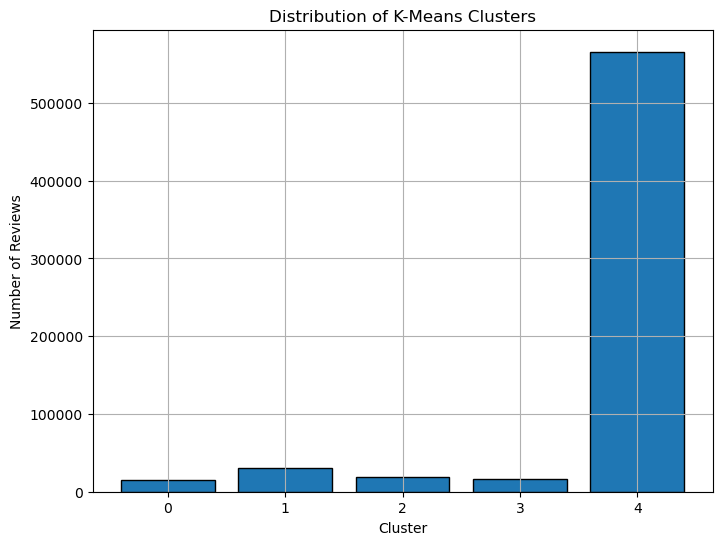

In [8]:
# K-Means Clustering on TF-IDF Features
num_clusters = 5
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
kmeans_labels = kmeans.fit_predict(X)

# Add cluster labels to sentiment_df.
sentiment_df['cluster'] = kmeans_labels

# Visualize cluster distribution.
cluster_counts = sentiment_df['cluster'].value_counts().sort_index()
plt.figure(figsize=(8, 6))
plt.bar(cluster_counts.index.astype(str), cluster_counts.values, edgecolor='black')
plt.title('Distribution of K-Means Clusters')
plt.xlabel('Cluster')
plt.ylabel('Number of Reviews')
plt.grid(True)
plt.show()


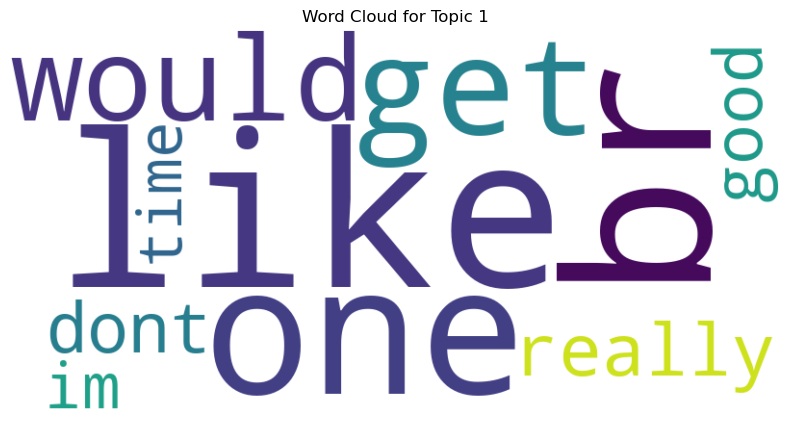

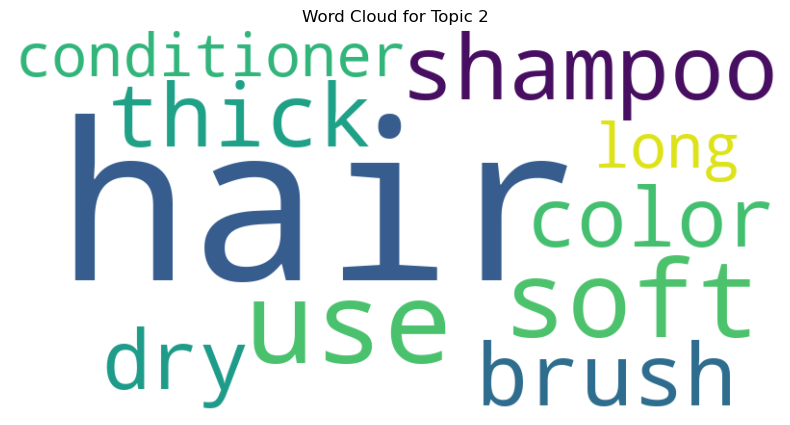

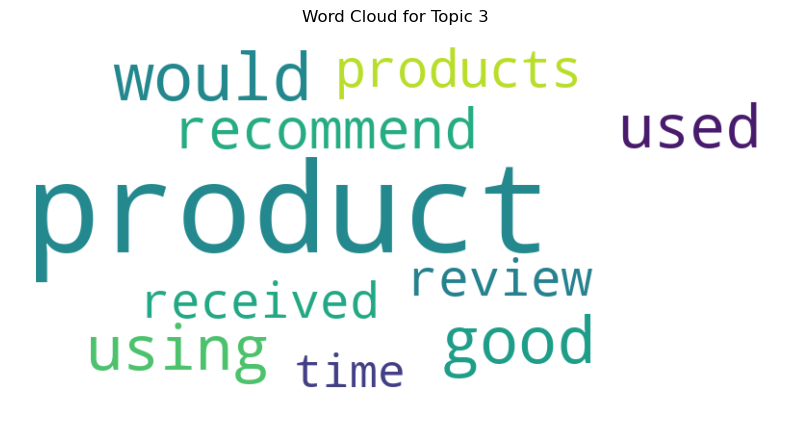

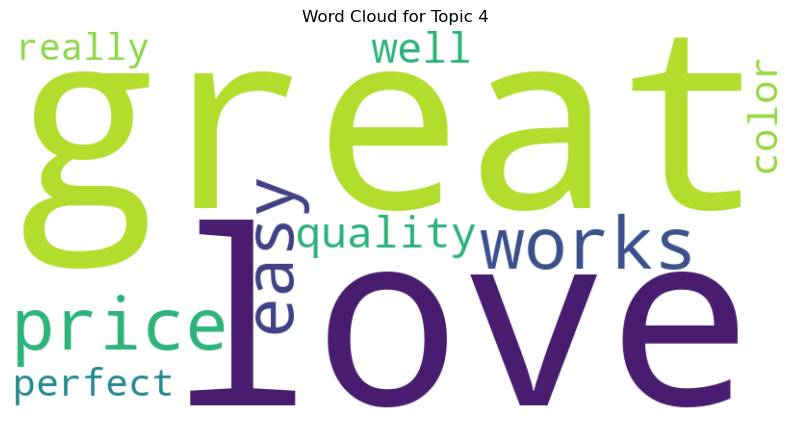

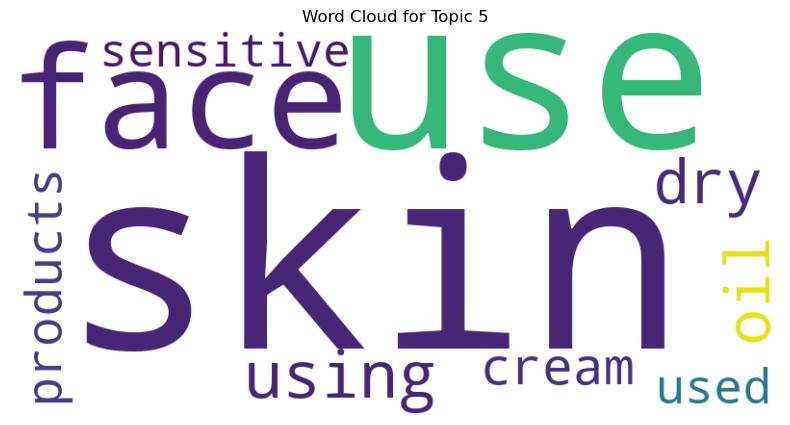

In [9]:
# Word Cloud for Each Topic
for topic_idx, topic in enumerate(H):
    top_features_ind = topic.argsort()[:-num_top_words - 1:-1]
    top_features = [feature_names[i] for i in top_features_ind]
    word_freq = {feature_names[i]: topic[i] for i in top_features_ind}
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(word_freq)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f"Word Cloud for Topic {topic_idx+1}")
    plt.axis('off')
    plt.show()


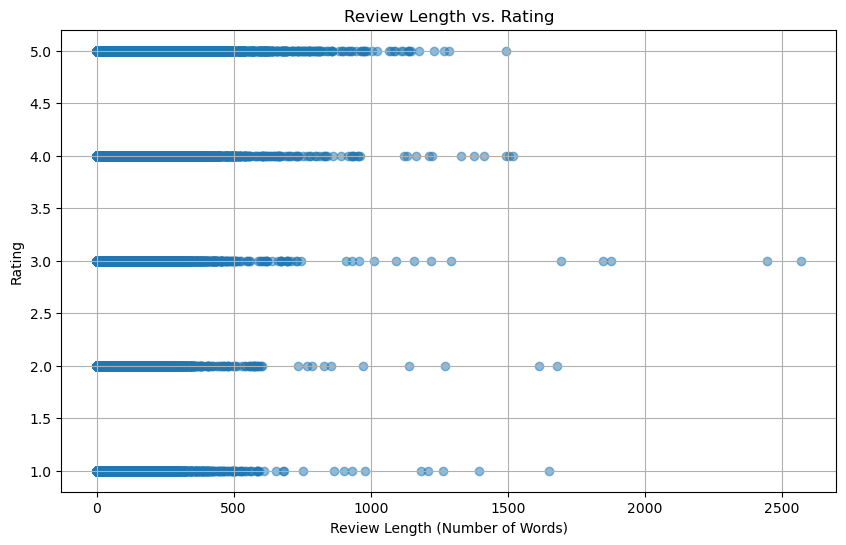

/tmp/ipykernel_22668/1538805100.py:18: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(lengths_by_rating, labels=ratings)


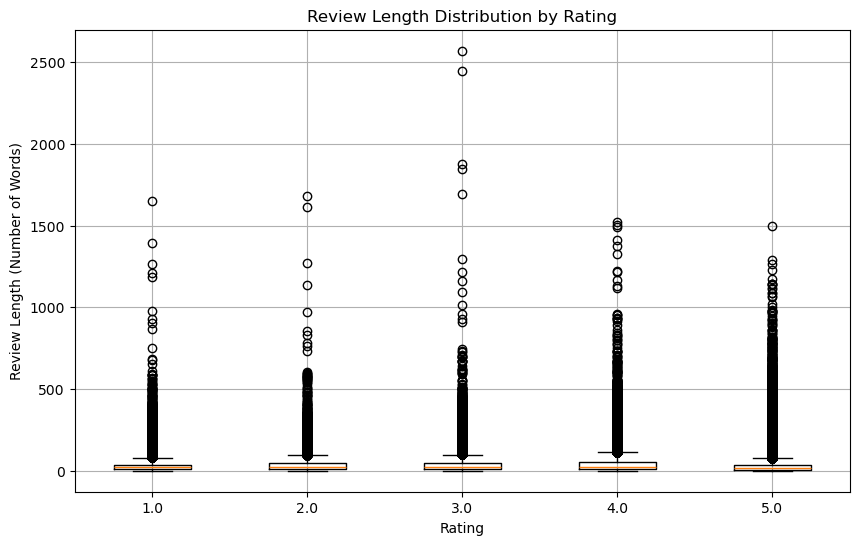

In [10]:
#  Review Length Analysis
reviews_df['review_length'] = reviews_df['cleaned_text'].apply(lambda x: len(x.split()))

# Scatter plot: Review length vs. Rating.
plt.figure(figsize=(10, 6))
plt.scatter(reviews_df['review_length'], reviews_df['rating'], alpha=0.5)
plt.title("Review Length vs. Rating")
plt.xlabel("Review Length (Number of Words)")
plt.ylabel("Rating")
plt.grid(True)
plt.show()

# Box plot: Review length distribution by Rating.
ratings = sorted(reviews_df['rating'].unique())
lengths_by_rating = [reviews_df[reviews_df['rating'] == r]['review_length'] for r in ratings]

plt.figure(figsize=(10, 6))
plt.boxplot(lengths_by_rating, labels=ratings)
plt.title("Review Length Distribution by Rating")
plt.xlabel("Rating")
plt.ylabel("Review Length (Number of Words)")
plt.grid(True)
plt.show()


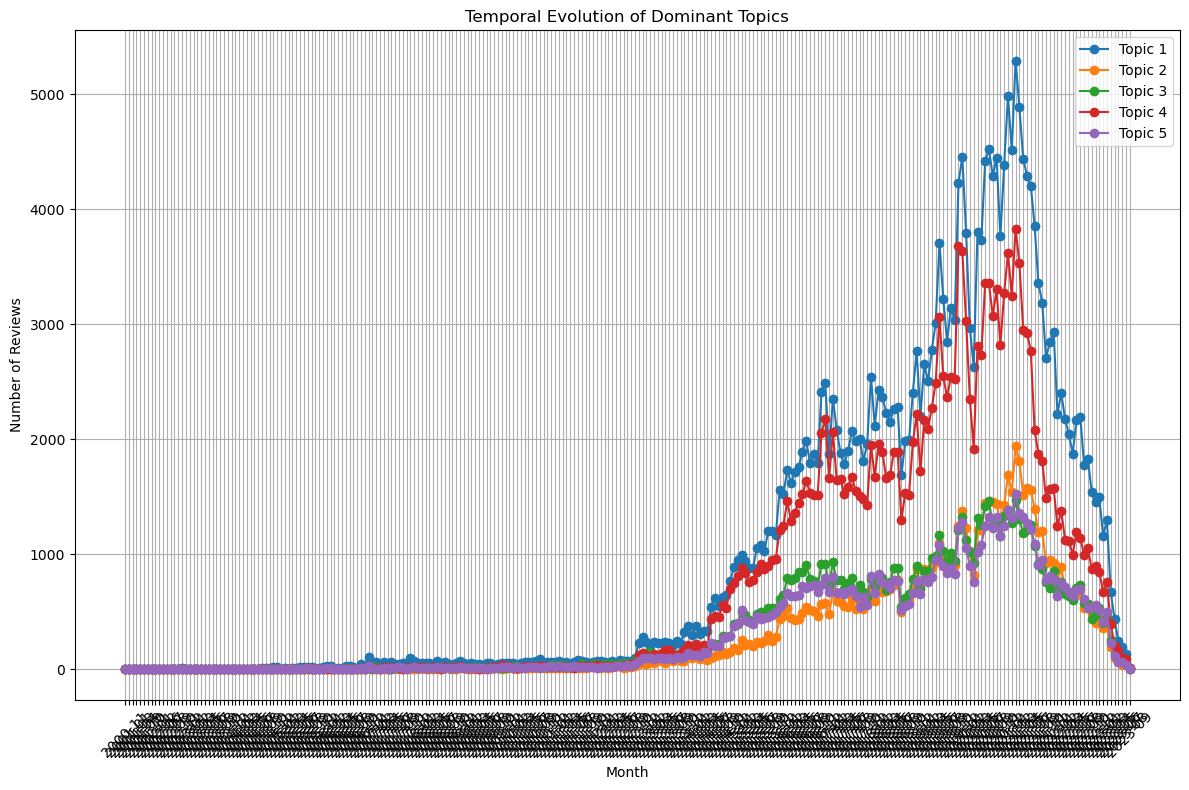

In [11]:
# Temporal Analysis of Topics
if 'datetime' not in reviews_df.columns:
    reviews_df['datetime'] = pd.to_datetime(reviews_df['timestamp'], unit='ms')

# Group reviews by month and dominant topic.
topic_over_time = reviews_df.groupby([reviews_df['datetime'].dt.to_period("M"), 'dominant_topic']).size().unstack(fill_value=0)

plt.figure(figsize=(12, 8))
for topic in topic_over_time.columns:
    plt.plot(topic_over_time.index.astype(str), topic_over_time[topic], marker='o', label=f"Topic {topic+1}")
plt.title("Temporal Evolution of Dominant Topics")
plt.xlabel("Month")
plt.ylabel("Number of Reviews")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
